In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint

# analytical bounds

In [2]:
@interact

def _( _d = slider(srange(.01,5,.1), default=0.5),
       _kappa = slider(srange(.1,10,0.1), default=1), ):
    
    dSquared = _d * _d
    pl  = plot( - dSquared + (1.+dSquared) / ( 1 + np.exp(_kappa/2 * np.log((2*x)**2)) / dSquared ), (x,-5,5), thickness=3 )
    pl += plot( -dSquared, (x,-5,5), color="gray", thickness=3 )
    pl.show()
    return

Widget Javascript not detected.  It may not be installed or enabled properly.


In [3]:
def kappa_cL_large (kappa, range=10) :
    xx = find_root(kappa/2 - x * arctan(x), 0, range)
    return kappa / (xx * np.exp( np.log(1+xx**2) / kappa ))

def kappa_cL_largeE (kappa) :
    """solution based on expansion of arctan"""
    DeltaKappa = 1. + (2./pi)**2 * (1.+kappa/2.)**2
    Delta = np.exp( np.log(DeltaKappa) / kappa )
    return pi / Delta


def kappa_cL_small (x, kappa) :
    return np.sqrt(2*kappa) * x / np.exp( np.log(1+kappa/2) * (0.5 + 1/kappa) )

def kappa_cU_large (kappa) :
    return  np.pi * np.sqrt(2/kappa) * np.exp( np.log(1+kappa/2) * (0.5 + 1/kappa) )

def kappa_cU_small (x, kappa) :
    return 2*kappa  * np.exp( (-1+1/kappa)*np.log(kappa-1) + (1-2/kappa)*np.log(x) )

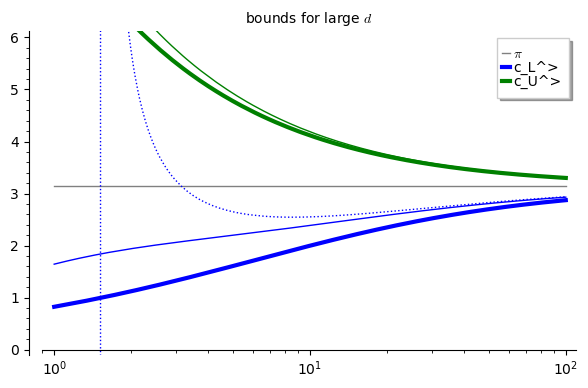

In [4]:
xMin = 1
xMax = 100

pLargeD  = plot( pi,  (x,xMin,xMax), legend_label=r"$\pi$", color="gray" )

pLargeD += plot( lambda x: kappa_cL_large(x, 100), (x,xMin,xMax), legend_label="c_L^>",
              thickness=3, )
pLargeD += plot( kappa_cL_largeE (x) , (x,xMin,xMax) , ymin=1e-2)
pLargeD += plot( pi / (1+(2/x) * np.log(x/np.pi)) , (x,xMin,xMax),
              color="blue", linestyle=":"  )


pLargeD += plot_semilogx( lambda x: kappa_cU_large(x), (x,xMin,xMax), legend_label="c_U^>", 
               thickness=3, color="green" )
pLargeD += plot_semilogx( pi / sqrt(x) * np.exp((0.5+1/x) * np.log(1+x)), (x,xMin,xMax),
              color="green"  )
# pLargeD += plot( pi * (1+1/(2*x)), (x,xMin,xMax),
#              color="green", linestyle=":"  )


pLargeD.show(scale="semilogx", title=r"bounds for large $d$",
            ymax=6)

### quality of approximation of $c_L^>$

In [5]:
def kappa_cL_large_ratio ( kappa, range=10) :
    xx = find_root(kappa/2 - x*arctan(x), 0, range)
    approx = kappa_cL_largeE(kappa)
    return approx * (xx * np.exp( np.log(1+xx**2) / kappa )) / kappa

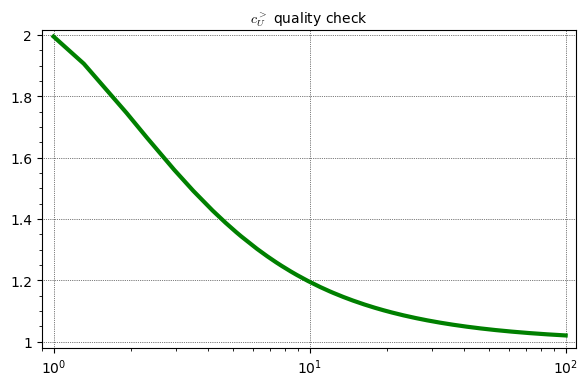

In [6]:
xMin = 1
xMax = 100

plot_semilogx( lambda x:  kappa_cL_large_ratio(x, 100), 
     (x,xMin,xMax), title=r"$c_U^>$ quality check", 
     thickness=3, color="green",
     ymin = 1,
     gridlines=True,
     frame = True )

In [7]:
for _kappa_ in range(1,11) :
    bound = kappa_cL_large_ratio( _kappa_ ).n()
    print( _kappa_, " :\t", bound )

1  :	 1.99440373636849
2  :	 1.72916892233561
3  :	 1.55434992764786
4  :	 1.44285090428208
5  :	 1.36707244353545
6  :	 1.31268110653256
7  :	 1.27193236134343
8  :	 1.24035610114552
9  :	 1.21521609936773
10  :	 1.19475311004224


# numerical evaluation of boundary

### integrate trajectories

In [8]:
## time array for ODE integration
tG = np.linspace(1e-8, 20, 1+20*100)

def kappa_integration (_c, _d, _kappa) :

    ##  initial condition for ODE
    yI = [0]
    
    ##  setup and solve ODE
    cSquared = _c * _c
    dSquared = _d * _d

    def ricc(z,t):
        dzdt = cSquared * z*z - dSquared + (1.+dSquared) / ( 1 + np.exp(_kappa/2 * np.log((2*t)**2)) / dSquared )
        return dzdt

    # return solution
    return odeint(ricc,yI,tG)

In [9]:
@interact

def _( _c = slider(srange(.01,5,.1), default=0.5),
       _d = slider(srange(.01,5,.1), default=0.5),
       _kappa = slider(srange(1,5,1), default=1), ):
    sol = kappa_integration (_c, _d, _kappa)
    
    yMin = - _d / _c
    yMax = - 2* yMin
    pl  = line( zip(tG,sol), thickness=5, ymin = yMin, ymax = yMax )
    pl += plot(-_d/_c, (x,0,20), color="gray")
    pl.show()
    return

Widget Javascript not detected.  It may not be installed or enabled properly.


## quality of approximation of $c(d)$ for $d \gg 1$ by comparison to numerical data

In [10]:
kappaMax = 100
kappaVals        = np.linspace(2, kappaMax, 1+(kappaMax-2)*4)
boundary_C_large = np.linspace(2, kappaMax, 1+(kappaMax-2)*4)

##  array with c-values  inspected to find the boundary
c_aux = np.linspace(0.5,3,1500)
c = 2**c_aux

i    =  0   # index for  kappa - values
j    =  0   # index for  c-values

dVal = 100

for _kappa_ in  kappaVals :          # index for  kappa-values
        zMax = 0   ## always enter the while loop

        ## increase  c-values   until  we hit a runaway trajectory
        while ( zMax <= dVal/c[j] ) :       
            ##  setup and solve ODE
            sol = kappa_integration (c[j], dVal, _kappa_)
        
            ## assign asymptotic value to  zMax
            zMax = np.amax(sol)

            ##  increase index for  c-value
            j += 1

        ##  store latest c-value  in  boundary_C_large
        j -= 1
        boundary_C_large[i] = c[j]
        # print( "kappa=", _kappa_, "\t C=", boundary_C_large[i] )
        i += 1


/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Figure 6a

In [11]:
xMin = 1
xMax = 1e2

plt_params = dict( scale="semilogx", 
              xmin = xMin, 
              xmax = xMax, 
              ymin = 0.5, 
              ymax = 4, 
              frame = True,
                  ticks = [[1,10,100],[1,2,3,4]],
                  # gridlines=True,
                  axes_labels = [r"$\kappa$", r"$c$"], 
                 )

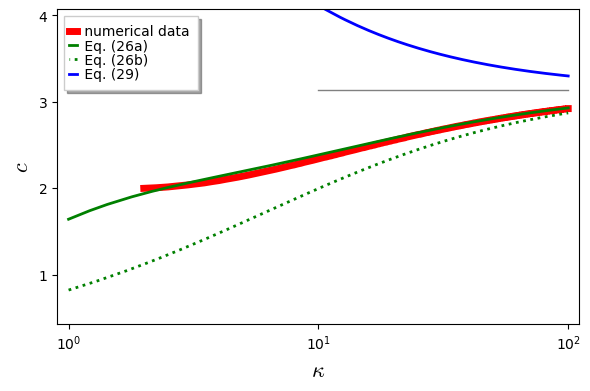

In [12]:
plotClarge  = plot(pi, (x,10,kappaMax), color="gray", **plt_params)

plotClarge += line( zip(kappaVals, boundary_C_large), 
                   color="red", thickness=5, legend_label=" numerical data", 
                   **plt_params)
plotClarge += plot( lambda x: kappa_cL_largeE(x), (x,1,kappaMax), 
                   color="green", thickness=2, legend_label=" Eq. (26a)", 
                   **plt_params)
plotClarge += plot( lambda x: kappa_cL_large(x, 100), (x,1,kappaMax), 
                   color="green", thickness=2, linestyle=":", legend_label=" Eq. (26b)",
                   **plt_params)


plotClarge += plot( lambda x: kappa_cU_large (x), (x,1,kappaMax), 
                   color="blue", thickness=2, legend_label=" Eq. (29)", 
                   **plt_params)

plotClarge.show( scale="semilogx",  frame=True )

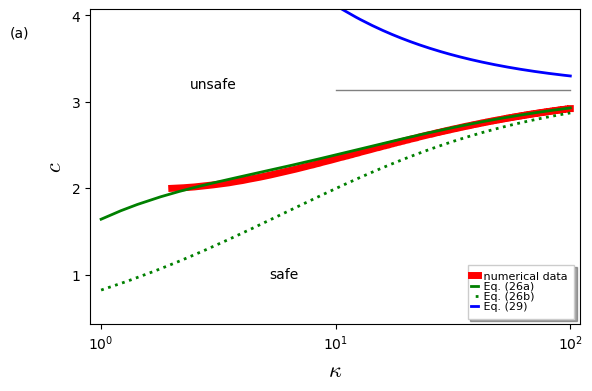

In [13]:
plotClarge.set_legend_options(font_size=8, loc=4)

bbox = {'boxstyle':"square", 'fc':"white", 'ec':"white", 'lw':2}
plotClargeLabels  = text("unsafe", (3, 3.2), fontsize=10,  color="black" )
plotClargeLabels += text("safe",  (6, 1.), fontsize=10, color="black", 
                            bounding_box=bbox)

plotClargeLabels += text("(a)", (0.45, 3.8), 
                         fontsize=10, color="black", 
                         bounding_box=bbox)

(plotClarge+plotClargeLabels).show( )

In [14]:
(plotClarge+plotClargeLabels).save_image("algebraic_large_d.pdf", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                **plt_params )
(plotClarge+plotClargeLabels).save_image("algebraic_large_d.png", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                **plt_params )

In [15]:
kappa_cL_largeVals = np.array( [ kappa_cL_large(_x_, 100) for _x_ in kappaVals ]  )
ratio = np.array( [ a/b for (a,b) in zip(boundary_C_large, kappa_cL_largeVals) ] )

/usr/lib/python3/dist-packages/sage/plot/graphics.py:2751: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  subplot.set_ylim([ymin, ymax])


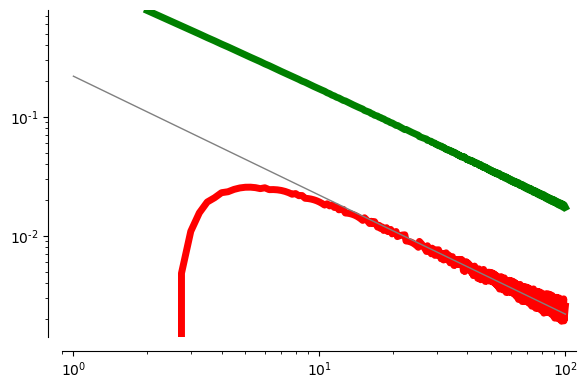

In [16]:
ratioP = line( zip(kappaVals, 1- boundary_C_large / kappa_cL_largeE(kappaVals)), color="red", thickness=5,
    xmin=1, 
    scale="semilogx")

ratioP += line( zip(kappaVals, ratio-1), color="green", thickness=5,
    xmin=1, 
    scale="loglog")
#    scale="semilogx")

ratioP += plot(0.22 * x**(-1), (x,1,100), color="gray")
    
ratioP

## calculate and plot boundary

In [17]:
##  array with d-values
d_aux = np.linspace(-20,10,300)
d = 2**d_aux

In [18]:
def kappa_boundary ( _kappa ) :
    ## array with tipping values  --- watch out: must have identical format as d_aux !!
    c_kappa = np.linspace(-20,10,300)

    ##  array with c-values  inspected to find the boundary
    c_aux = np.linspace(-20,10,5000)
    c = 2**c_aux

    j    =  0   # index for  c-values
    zMax = -1

    for i in range (0,300) :          # index for  d-values
        ## increase  c-values   until  we hit a runaway trajectory
        while ( zMax <= d[i]/c[j] ) :       
            ##  setup and solve ODE
            sol = kappa_integration (c[j], d[i], _kappa)
        
            ## assign asymptotic value to  zMax
            zMax = np.amax(sol)

            ##  increase index for  c-value
            j += 1

        ##  store latest c-value  in  c_tip
        j -= 1
        c_kappa[i] = c[j]
        zMax = 0
        # print( "i=", i, "\t d=", d[i], "\t C=", c[j] )
        
    return c_kappa

In [19]:
def kappa_boundary_plot ( _kappa, _c_kappa, xMin = 1e-6, xMax = 1e3, lineColor="red", lineThickness=3, **plt_params ) :

    ptkappa  = line( zip(d, _c_kappa), color=lineColor,  thickness=lineThickness,
                    legend_label=r"$%.1f$"%_kappa )

    ptkappa += plot( lambda x: kappa_cL_small(x, _kappa), (x,xMin,.1), thickness=2, linestyle=":", color="green")
    ptkappa += plot( lambda x: kappa_cL_large(   _kappa), (x,1,xMax),  thickness=2, linestyle=":", color="green")

    ptkappa += plot( lambda x: kappa_cU_small(x, _kappa), (x,xMin,.1), thickness=2, linestyle=":", color="blue")
    ptkappa += plot( lambda x: kappa_cU_large(   _kappa), (x,1,xMax),  thickness=2, linestyle=":", color="blue")

    ptkappa += plot( pi, (x,1,xMax),  thickness=1, color="gray")   
    
    return ptkappa

### $\kappa = 1.5$

/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


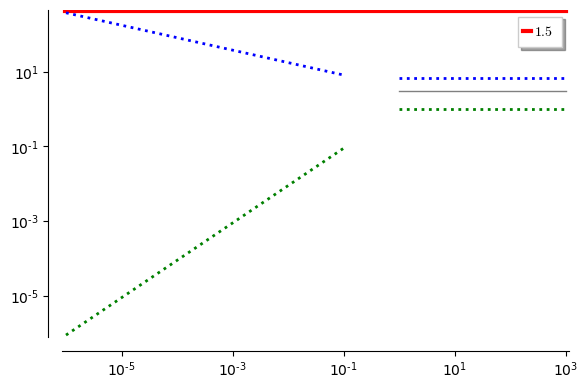

In [20]:
kappa = 1.5

c_kappa1_5 = kappa_boundary (kappa)

pBoundary1_5 = kappa_boundary_plot ( kappa, c_kappa1_5 )
pBoundary1_5.show( scale="loglog" )

### $\kappa = 2.0$

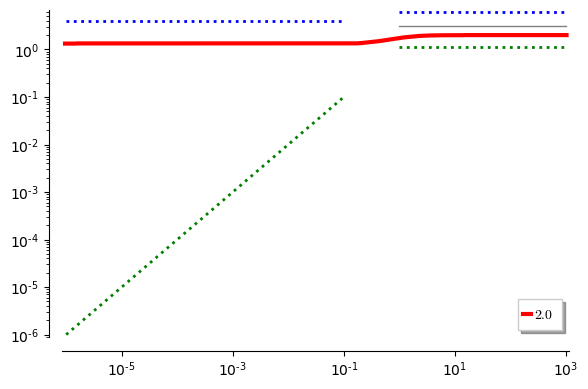

In [21]:
kappa = 2.0

c_kappa02 = kappa_boundary (kappa)

pBoundary02 = kappa_boundary_plot ( kappa, c_kappa02 )
pBoundary02.show( scale="loglog" )

### $\kappa = 3.0$

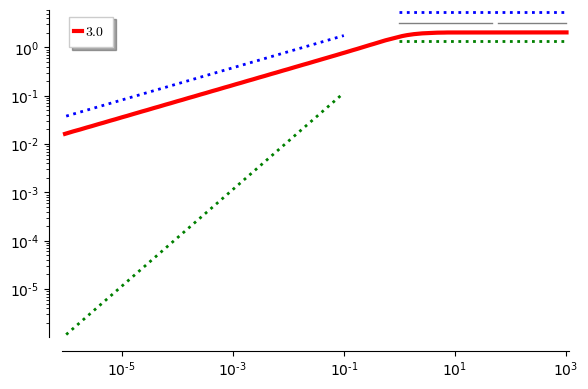

In [22]:
kappa = 3.0

c_kappa03 = kappa_boundary (kappa)

pBoundary03 = kappa_boundary_plot ( kappa, c_kappa03 )
pBoundary03.show( scale="loglog" )

### $\kappa = 4.0$

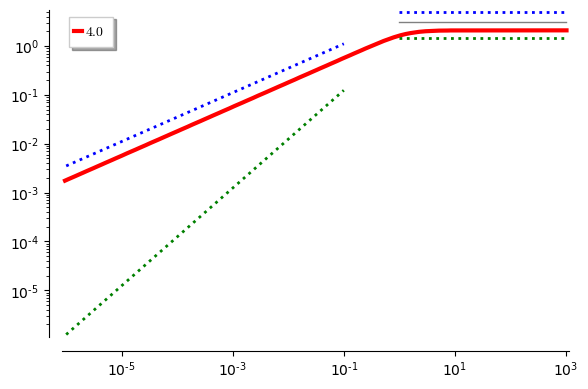

In [23]:
kappa = 4.0

c_kappa04 = kappa_boundary (kappa)

pBoundary04 = kappa_boundary_plot ( kappa, c_kappa04 )
pBoundary04.show( scale="loglog" )

### $\kappa = 6.0$

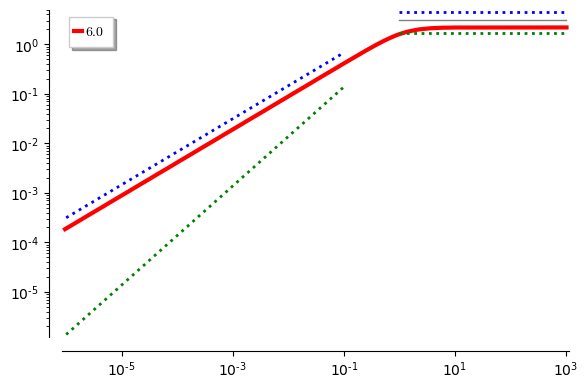

In [24]:
kappa = 6.0

c_kappa06 = kappa_boundary (kappa)

pBoundary06 = kappa_boundary_plot ( kappa, c_kappa06 )
pBoundary06.show( scale="loglog" )

### $\kappa = 8.0$

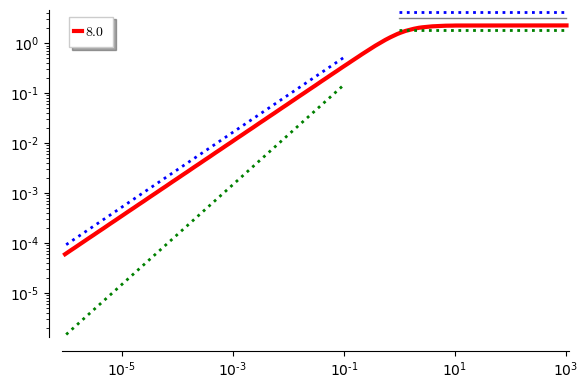

In [25]:
kappa = 8.0

c_kappa08 = kappa_boundary (kappa)

pBoundary08 = kappa_boundary_plot ( kappa, c_kappa08 )
pBoundary08.show( scale="loglog" )

### $\kappa = 10.0$

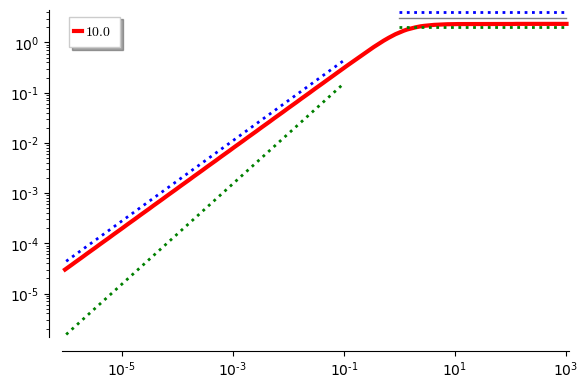

In [26]:
kappa = 10.0

c_kappa10 = kappa_boundary (kappa)

pBoundary10 = kappa_boundary_plot ( kappa, c_kappa10 )
pBoundary10.show( scale="loglog" )

### $\kappa = 16.0$

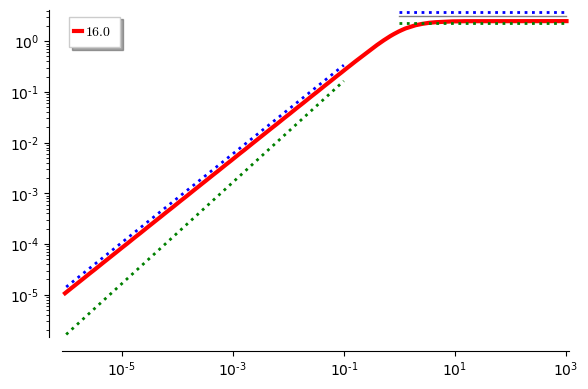

In [27]:
kappa = 16.0

c_kappa16 = kappa_boundary (kappa)

pBoundary16 = kappa_boundary_plot ( kappa, c_kappa16 )
pBoundary16.show( scale="loglog" )

## overview: upper boundaries for small $d$

In [28]:
def kappa_overview_plot ( _kappa, _c_kappa, lineColor="red", lineThickness=1, **plt_params ) :

    ptkappa  = line( zip(d, _c_kappa), color=lineColor,  thickness=lineThickness,
                    legend_label=r"$%.0f$"%_kappa,
                    **plt_params )

    ptkappa += plot( lambda x: kappa_cU_small(x, _kappa), (x,xMin,.1), 
                    thickness=lineThickness, linestyle=":", color=lineColor,
                    **plt_params )

    return ptkappa

In [29]:
xMin = 1e-6
xMax = 1e3
plt_params = dict( scale="loglog", 
              xmin = xMin, 
              xmax = xMax, 
              ymin = 1e-5, 
              ymax = 20, 
              ticks = [[1e-6,1e-3,1,1e3],[1e-4,1e-2,1]],
              axes_labels = [r"$d$",r"$c$"],
                  frame = True,
             )

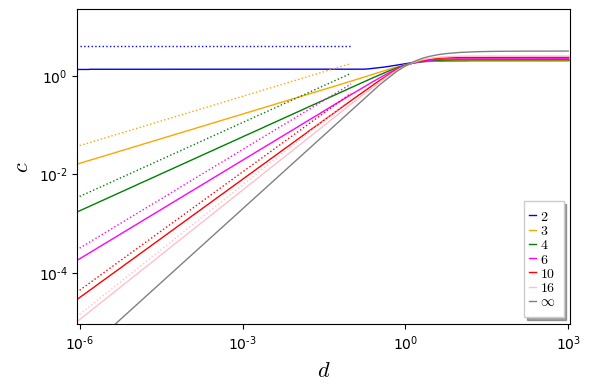

In [30]:
ptkappa  = kappa_overview_plot (  2,  c_kappa02,  lineColor="blue",  **plt_params )
ptkappa += kappa_overview_plot (  3,  c_kappa03,  lineColor="orange", **plt_params )
ptkappa += kappa_overview_plot (  4,  c_kappa04,  lineColor="green", **plt_params )
ptkappa += kappa_overview_plot (  6,  c_kappa06,  lineColor="magenta", **plt_params )
ptkappa += kappa_overview_plot ( 10,  c_kappa10,  lineColor="red", **plt_params )
ptkappa += kappa_overview_plot ( 16,  c_kappa16,  lineColor="pink", **plt_params )

ptkappa += plot( 2*atan(x), (x,xMin,xMax), thickness=1, color="gray", legend_label=r"$\infty$")

ptkappa.show()

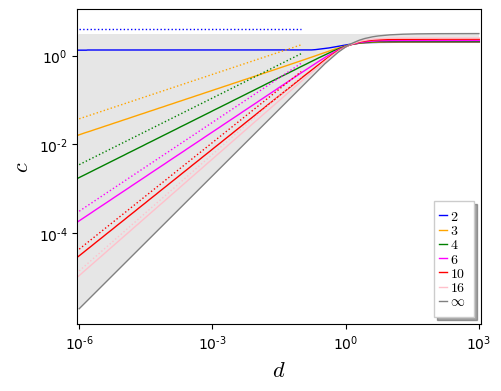

In [31]:
ptkappa_fill  = polygon(  [ [x,y] for [x,y] in zip(         d,  2*np.arctan(d))   ]
                        + [ [x,y] for [x,y] in zip( np.flip(d), 3*np.exp(0*d) ) ], 
                        rgbcolor=(0.9,0.9,0.9))
ptkappa_fill += polygon(  [ [xMin,2], [xMax,2], [xMax,pi], [xMin,pi] ], 
                        rgbcolor=(0.9,0.9,0.9))

( ptkappa_fill + ptkappa ).show( scale="loglog", ymin=1e-6, ymax=10 )

# Figure 6b

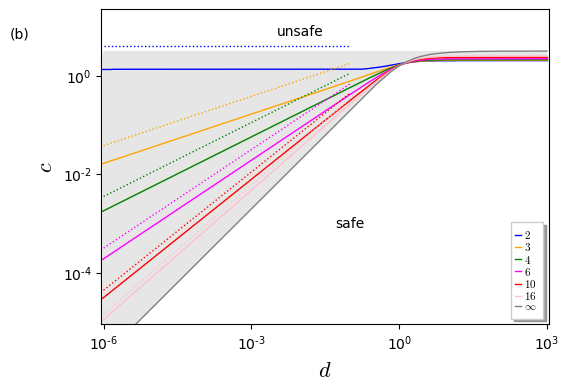

In [32]:
ptkappa.set_legend_options(font_size=8)

bbox = {'boxstyle':"square", 'fc':"white", 'ec':"white", 'lw':2}
ptkappa_text  = text("unsafe", (.01,  8), fontsize=10,  color="black" )
ptkappa_text += text("safe",  (.1, 1e-3), fontsize=10, color="black",
                            bounding_box=bbox)

ptkappa_text += text("(b)", (2e-8, 7), 
                         fontsize=10, color="black", 
                         bounding_box=bbox)

(ptkappa_text + ptkappa_fill + ptkappa).show( )

In [33]:
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_c-d.pdf", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                   **plt_params )
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_c-d.png", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                   **plt_params )

# Figure 7.
## overview: lower boundaries for small $d$

In [34]:
def kappa_cL_small_2step (x, kappa) :
    factor1 = np.exp( np.log(x) * (1 - 2/(1+kappa)) )
    factor2 = np.exp( np.log(kappa) * (1.5 - 1/(1+kappa)) ) 
    factor3 = np.exp( np.log(1+kappa*(1+kappa)/2) * (-0.5 - 1/(kappa*(1+kappa))) ) 
    factor4 = np.sqrt(2/(1+kappa))
    return factor1 * factor2 * factor3 * factor4

In [35]:
def kappa_2step_overview_plot ( _kappa, _c_kappa, lineColor="red", lineThickness=1, **plt_params ) :

    ptkappa  = line( zip(d, _c_kappa), color=lineColor,  thickness=lineThickness,
                    legend_label=r"$%.0f$"%_kappa,
                    **plt_params )

#    ptkappa += plot( lambda x: kappa_cU_small(x, _kappa), (x,xMin,.1), 
#                    thickness=lineThickness, linestyle=":", color=lineColor,
#                    **plt_params )
    ptkappa += plot( lambda x: kappa_cL_small_2step(x, _kappa), (x,xMin,.1), 
                    thickness=lineThickness, linestyle=":", color=lineColor,
                    **plt_params )

    return ptkappa

In [36]:
xMin = 1e-6
xMax = 1e3
plt_params = dict( scale="loglog", 
              xmin = xMin, 
              xmax = xMax, 
              ymin = 1e-5, 
              ymax = 20, 
              ticks = [[1e-6,1e-3,1,1e3],[1e-4,1e-2,1]],
              axes_labels = [r"$d$",r"$c$"],
                  frame = True,
             )

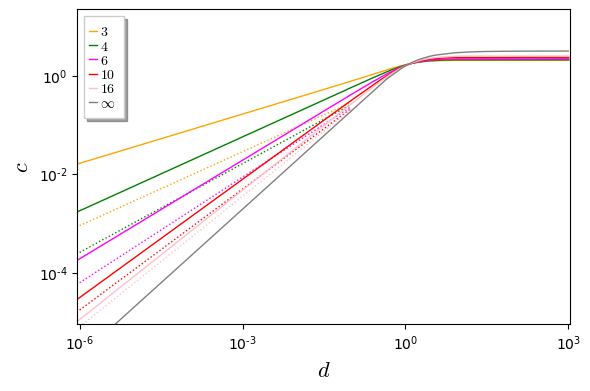

In [37]:
# ptkappa  = kappa_2step_overview_plot (  2,  c_kappa02,  lineColor="blue",  **plt_params )
ptkappa  = kappa_2step_overview_plot (  3,  c_kappa03,  lineColor="orange", **plt_params )
ptkappa += kappa_2step_overview_plot (  4,  c_kappa04,  lineColor="green", **plt_params )
ptkappa += kappa_2step_overview_plot (  6,  c_kappa06,  lineColor="magenta", **plt_params )
ptkappa += kappa_2step_overview_plot ( 10,  c_kappa10,  lineColor="red", **plt_params )
ptkappa += kappa_2step_overview_plot ( 16,  c_kappa16,  lineColor="pink", **plt_params )

ptkappa += plot( 2*atan(x), (x,xMin,xMax), thickness=1, color="gray", legend_label=r"$\infty$")

ptkappa.show()

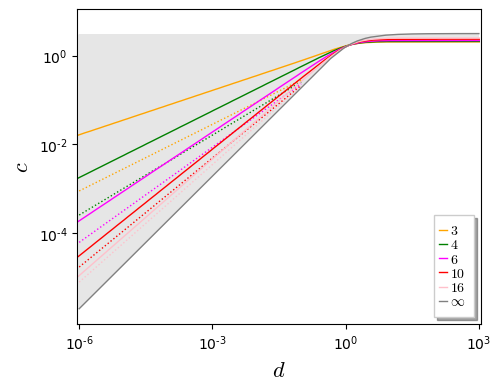

In [38]:
ptkappa_fill  = polygon(  [ [x,y] for [x,y] in zip(         d,  2*np.arctan(d))   ]
                        + [ [x,y] for [x,y] in zip( np.flip(d), 3*np.exp(0*d) ) ], 
                        rgbcolor=(0.9,0.9,0.9))
ptkappa_fill += polygon(  [ [xMin,2], [xMax,2], [xMax,pi], [xMin,pi] ], 
                        rgbcolor=(0.9,0.9,0.9))

( ptkappa_fill + ptkappa ).show( scale="loglog", ymin=1e-6, ymax=10 )

In [39]:
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_c-d_2step.pdf", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                   **plt_params )
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_c-d_2step.png", transparent=True, 
              fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                   **plt_params )

# Gaussian overshoot

In [40]:
def gauss_integration (_c, _d) :

    ##  initial condition for ODE
    yI = [0]
 
    ##  setup and solve ODE
    cSquared = _c * _c
    dSquared = _d * _d
    gRate = 4 * np.log(1.+1./dSquared)

    def ricc(z,t):
        dzdt = cSquared * z*z - dSquared + (1+dSquared) * np.exp( -t**2 * gRate )
        return dzdt

    # return solution
    return odeint(ricc,yI,tG)

In [41]:
##  array with c-values
c_aux = np.linspace(-20,10,5000)
c = 2**c_aux

## array with tipping values
c_Gauss = np.linspace(-20,10,300)



j    =  0   # index for  c-values
zMax = 0

for i in range (0,300) :          # index for  d-values
    ## increase  c-values   until  we hit a runaway trajectory
    while ( zMax <= d[i]/c[j] ) :       
        ##  setup and solve ODE
        sol = gauss_integration (c[j], d[i])
        
        ## assign asymptotic value to  zMax
        zMax = np.amax(sol)

        ##  increase index for  c-value
        j += 1

    ##  store latest c-value  in  c_tip
    j -= 1
    c_Gauss[i] = c[j]
    zMax = 0
    # print( "i=", i, "\t d=", d[i], "\t C=", c[j] )

/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Figure 1

In [42]:
xMin = 1e-3
xMax = 1e6
xLarge = 1e2

# ptkappa = plot(3/sqrt(x), (x,xMin,xMax), thickness=3, color="gold", legend_label=r"$3 / \sqrt{H}$")
ptkappa = plot(3/sqrt(x), (x,xMin,xMax), thickness=3, color="black", linestyle=":", legend_label=r"literature")


ptkappa += line( zip(1/d**2, d*c_kappa02), thickness=2, color="blue", legend_label=r"Cauchy",
    axes_labels = [r"$H = R/R_d$", r"$T=\sqrt{k\, R_d} \; t_e$"],
     gridlines = True,
     xmax = xMax
    )
# ptkappa += plot(2*x**(-1+0.5/1.), (x,xLarge,xMax), thickness=2, linestyle=":", color="blue")

ptkappa += line( zip(1/d**2, d*c_kappa03), thickness=2, color="orange", legend_label=r"$3$", )
# ptkappa += plot(2*x**(-1+0.5/1.5), (x,xLarge,xMax), thickness=2, linestyle=".", color="pink")

ptkappa += line( zip(1/d**2, d*c_kappa04), thickness=2, color="green", legend_label=r"$4$"    )
# ptkappa += plot(2*x**(-1+0.5/2.), (x,xLarge,xMax), thickness=2, linestyle=":", color="green")

# ptkappa += line( zip(1/d**2, d*c_kappa3), color="red", legend_label=r"$6$",    )
# ptkappa += plot(2*x**(-1+0.5/3.), (x,xLarge,xMax), thickness=2, linestyle=":", color="red")

# ptkappa += line( zip(1/d**2, d*c_kappa4), color="black", legend_label=r"$4$",    )
# ptkappa += plot(2*x**(-1+0.5/4.), (x,xLarge,xMax), thickness=2, linestyle=":", color="black")

#ptkappa += line( zip(1/d**2, d*c_kappa8), color="magenta", legend_label=r"$8$",    )
#ptkappa += plot(2*x**(-1+0.5/8.), (x,xLarge,xMax), thickness=2, linestyle=":", color="magenta")

ptkappa += line( zip(1/d**2, d*c_Gauss), thickness=2, color="red", legend_label=r"Gaussian",    )

ptkappa += plot_loglog( 2*atan(1/sqrt(x)) / sqrt(x), (x,xMin,xMax), plot_points=20000, 
                       thickness=2, color="gray", legend_label=r"rectangular")


ptkappa_fill  = plot_loglog( [3/sqrt(x), 2*atan(1/sqrt(x)) / sqrt(x) ], (x,xMin,xMax), 
                       plot_points=20000, fill={0:[1]}, fillcolor="lightgray")
ptkappa_fill += plot_loglog( [3/sqrt(x), 2/sqrt(x) ], (x,xMin,1e-2), 
                       plot_points=20000, fill={0:[1]}, fillcolor="lightgray")


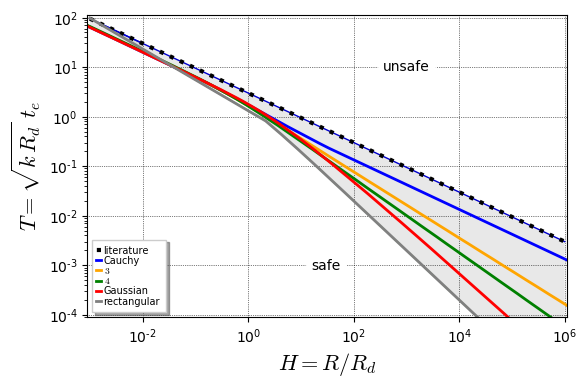

In [43]:
bbox = {'boxstyle':"square", 'fc':"white", 'ec':"white", 'lw':2}
ptkappa_text  = text("unsafe", (1e3,   10), fontsize=10,  color="black",
                            bounding_box=bbox)
ptkappa_text += text("safe",  (30, 1e-3), fontsize=10, color="black",
                            bounding_box=bbox)
ptkappa_text.set_legend_options(font_size=7, loc=3)


plt_params = dict( scale="loglog", 
              xmin = xMin, 
              xmax = xMax, 
              ymin = 1e-4, 
              ymax = 100, 
              frame = True,
                 )
(ptkappa_text + ptkappa_fill + ptkappa).show( **plt_params )

In [44]:
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_T-H.pdf", transparent=True, 
               fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                  **plt_params )
(ptkappa_text + ptkappa_fill + ptkappa).save_image("overshoot_T-H.png", transparent=True, 
               fontsize=8,                  # size of text font
              figsize=(3.6,2.4),                # figure size)
                                                   **plt_params )

In [51]:
(2*arctan(4/pi) / sqrt(1+16/pi**2)).n()

1.11800665284289